#Import library

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, LSTM, Dense, Dropout, ELU, Input, SimpleRNN
from keras.models import Sequential
from keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud, STOPWORDS

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
stop_words=stopwords.words('english')

#Read Data

In [4]:
df = pd.read_csv('/content/data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
df.isnull().sum()

,0
Sentence,0
Sentiment,0


In [6]:
df.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [8]:
df.duplicated().sum()

6

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.duplicated().sum()

0

In [11]:
def columns_info(df):
  cols = []
  dtypes = []
  unique_v = []
  n_unique_v= []

  for col in df.columns:
    cols.append(col)
    dtypes.append(df[col].dtypes)
    unique_v.append(df[col].unique())
    n_unique_v.append(df[col].nunique())

  return pd.DataFrame({'Name':cols, 'Types':dtypes, 'Unique':unique_v, 'N_Unique':n_unique_v})

In [12]:
columns_info(df)

,Name,Types,Unique,N_Unique
0,Sentence,object,[The GeoSolutions technology will leverage Ben...,5322
1,Sentiment,object,"[positive, negative, neutral]",3


In [13]:
class_names = ['negative', 'neutral', 'positive']

#Text Visualization

In [14]:
neutral_data = list(df['Sentence'][df['Sentiment'] == 'neutral'].values)
positive_data = list(df['Sentence'][df['Sentiment'] == 'positive'].values)
negative_data = list(df['Sentence'][df['Sentiment'] == 'negative'].values)

In [15]:
neutral_data_string = ' '.join(neutral_data)
positive_data_string = ' '.join(positive_data)
negative_data_string = ' '.join(negative_data)

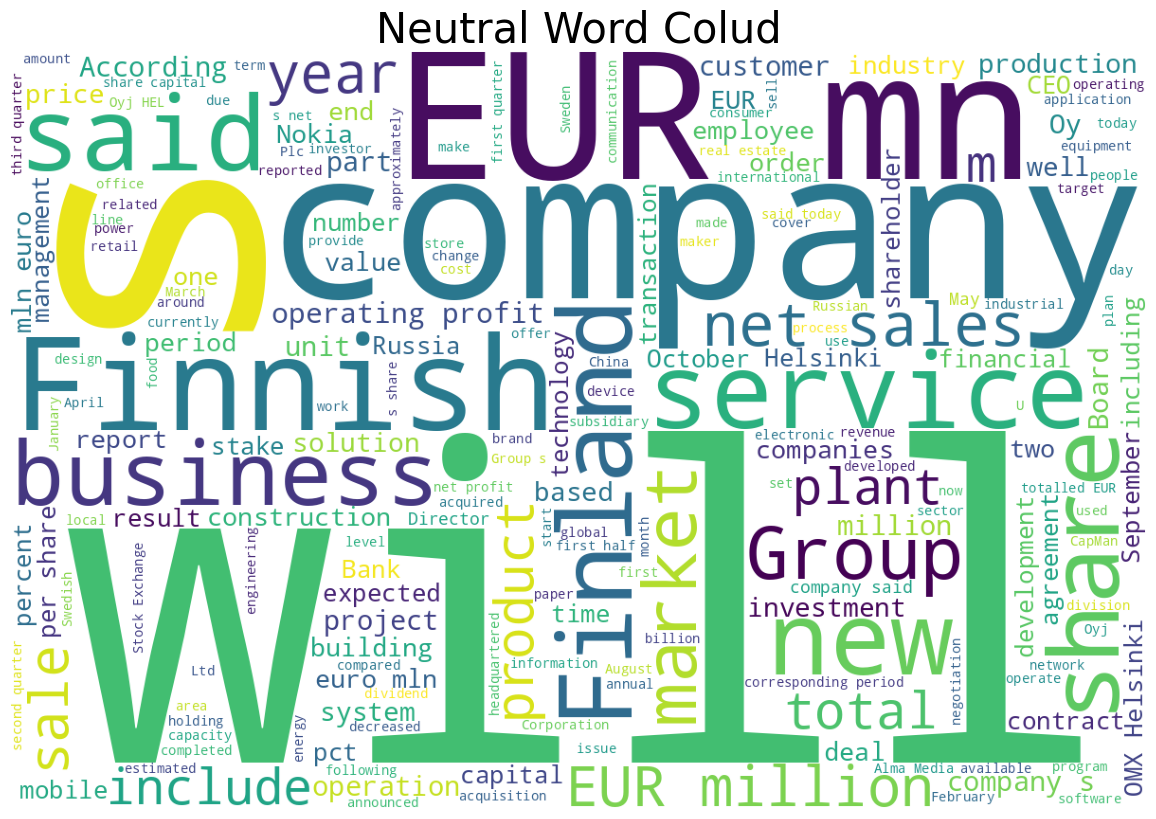

In [16]:
wordcloud = WordCloud(width=1200, height=800, background_color='white', stopwords=STOPWORDS,min_font_size = 10).generate(neutral_data_string)

plt.figure(figsize = (12, 8), facecolor = None)
plt.title("Neutral Word Colud", fontdict={'fontsize' : 30})
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

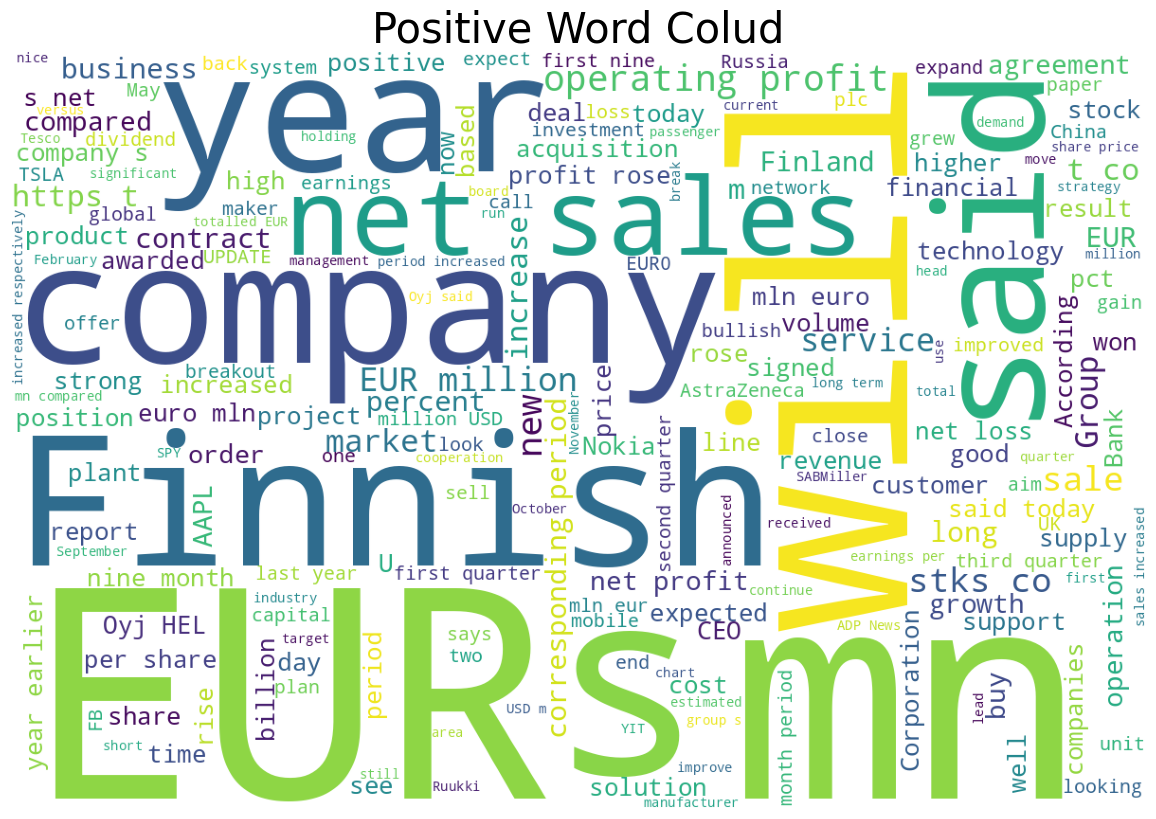

In [17]:
wordcloud = WordCloud(width=1200, height=800, background_color='white', stopwords=STOPWORDS,min_font_size = 10).generate(positive_data_string)

plt.figure(figsize = (12, 8), facecolor = None)
plt.title("Positive Word Colud", fontdict={'fontsize' : 30})
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

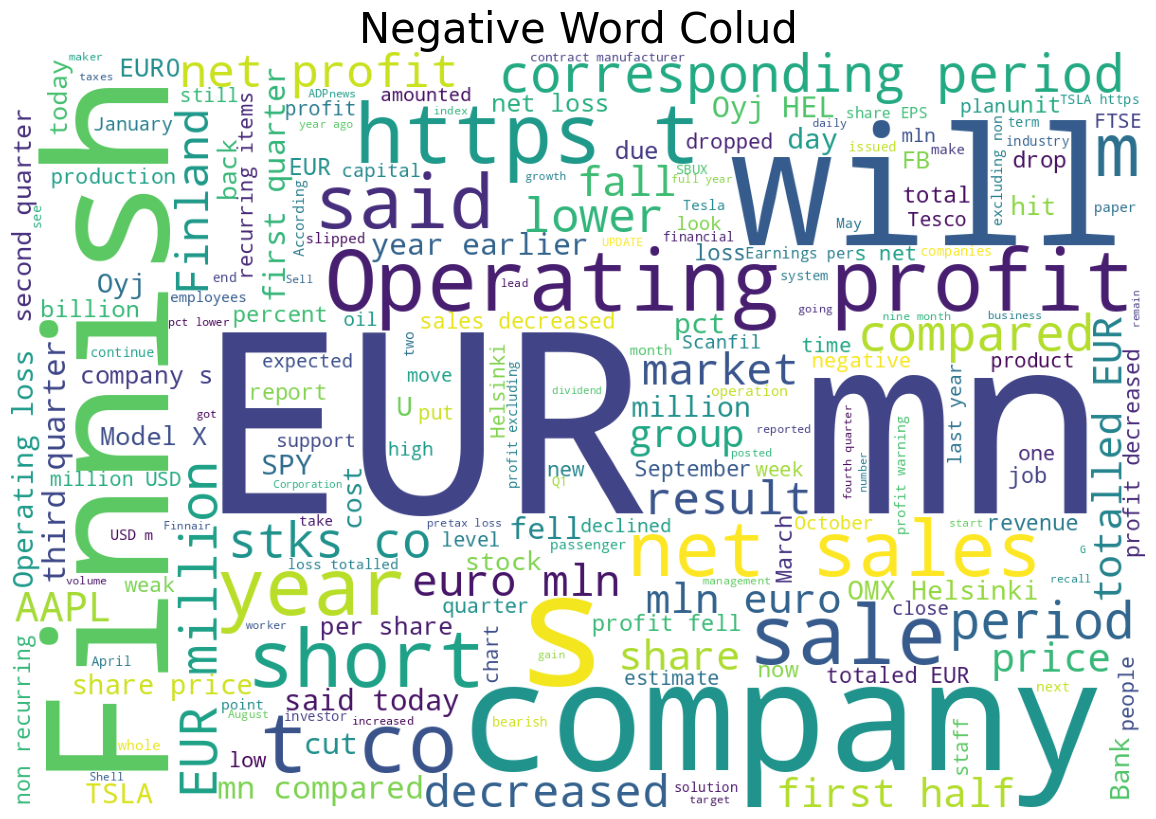

In [18]:
wordcloud = WordCloud(width=1200, height=800, background_color='white', stopwords=STOPWORDS,min_font_size = 10).generate(negative_data_string)

plt.figure(figsize = (12, 8), facecolor = None)
plt.title("Negative Word Colud", fontdict={'fontsize' : 30})
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

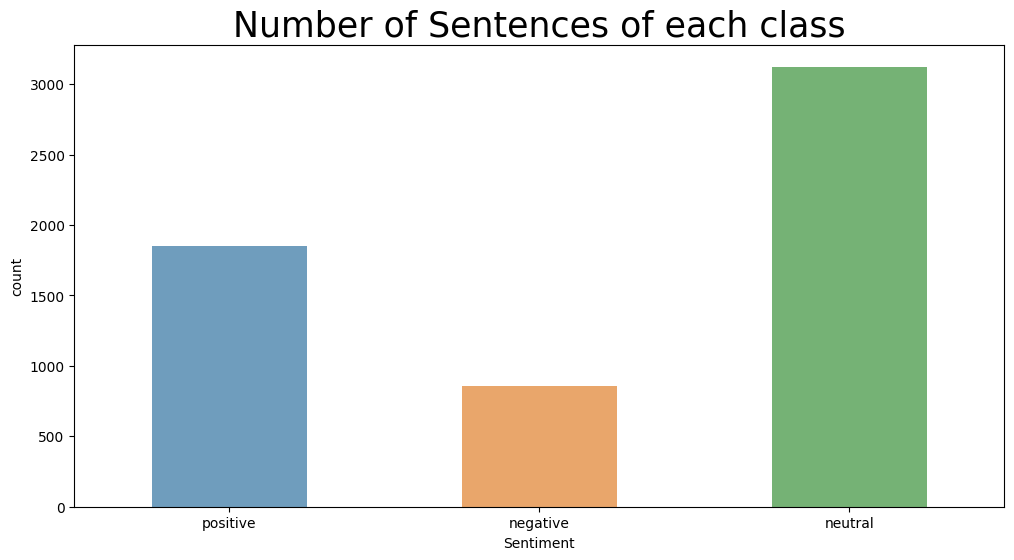

In [19]:
plt.figure(figsize=(12,6))
plt.title("Number of Sentences of each class", fontdict={'fontsize' : 25})
sns.countplot(x=df['Sentiment'], hue=df['Sentiment'], alpha=0.7, width=.5)
plt.show()

#Text Preprocessing

In [20]:
def clean_text(sentence):
  sentence = re.sub('(#|@)\w*',' ',sentence)
  sentence = re.sub('https?:\/\/\S',' ',sentence)
  sentence = re.sub('(\?|!)',' ',sentence)
  sentence = re.sub('(\.|\,)',' ',sentence)
  sentence = re.sub('[_:()\\\]',' ',sentence)
  sentence = re.sub('^\s+',' ',sentence)
  sentence = re.sub('[$]',' ',sentence)
  sentence = re.sub('^\s',' ',sentence)
  sentence = re.sub('\s+$',' ',sentence)
  sentence = re.sub('\s\d+\s',' ',sentence)
  return sentence

In [21]:
def preprocessing(sentences):
  clean_sentences=[]
  for sentence in sentences:
    clean_sentence = clean_text(sentence)
    clean_sentence = nltk.word_tokenize(clean_sentence)
    clean_sentence = [word.lower()  for word in clean_sentence if word.lower() not in stop_words]
    lemmatizer = WordNetLemmatizer()
    clean_sentence = [lemmatizer.lemmatize(word) for word in clean_sentence]
    clean_sentences.append(' '.join(clean_sentence))

  return clean_sentences

In [22]:
df['Sentence'][2]

"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m ."

In [23]:
#Sentence pefore preprocessing
df['Sentence'][0]

"The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model ."

In [24]:
df['Sentence'][82]

"The Brazilian unit of Finnish security solutions provider F-Secure signed up 1,500 new clients last year , online news source Reseller Web quoted the division 's commercial director , Vladimir Brand+úo , as saying ."

In [25]:
df['Sentence'] = preprocessing(df['Sentence'])

In [26]:
#Sentence after preprocessing
df['Sentence'][0]

"geosolutions technology leverage benefon 's gps solution providing location based search technology community platform location relevant multimedia content new powerful commercial model"

In [27]:
df['Sentence'][82]

"brazilian unit finnish security solution provider f-secure signed 500 new client last year online news source reseller web quoted division 's commercial director vladimir brand+úo saying"

In [28]:
df['Sentiment'].value_counts()

,count
Sentiment,
neutral,3124
positive,1852
negative,860


In [29]:
ros = RandomOverSampler(random_state=42)
x_res, y_res = ros.fit_resample(df[['Sentence']], df['Sentiment'])

balanced_data = pd.DataFrame({
    'Sentence' : x_res['Sentence'],
    'Sentiment' : y_res
})

In [30]:
balanced_data['Sentiment'].value_counts()

,count
Sentiment,
positive,3124
negative,3124
neutral,3124


In [31]:
encoder = OneHotEncoder()
sentiment = encoder.fit_transform(balanced_data[['Sentiment']])
df_encoded = pd.DataFrame(sentiment.toarray(), columns=encoder.get_feature_names_out())
df_encoded.rename(columns={'Sentiment_negative': 'Negative', 'Sentiment_neutral': 'Neutral','Sentiment_positive': 'Positive'}, inplace=True)

In [32]:
df_encoded.head()

,Negative,Neutral,Positive
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [33]:
data = pd.concat([balanced_data, df_encoded], axis=1)
data.drop('Sentiment', inplace=True, axis=1)

In [34]:
data.head()

,Sentence,Negative,Neutral,Positive
0,geosolutions technology leverage benefon 's gp...,0.0,0.0,1.0
1,esi low 50 50 bk real possibility,1.0,0.0,0.0
2,last quarter componenta 's net sale doubled eu...,0.0,0.0,1.0
3,according finnish-russian chamber commerce maj...,0.0,1.0,0.0
4,swedish buyout firm sold remaining 4 percent s...,0.0,1.0,0.0


In [35]:
tokenizer=Tokenizer(num_words=5843,oov_token='<OOV>')
tokenizer.fit_on_texts(data['Sentence'])
x=tokenizer.texts_to_sequences(data['Sentence'])
x=pad_sequences(x)
x

array([[   0,    0,    0, ..., 3976,  641,  166],
       [   0,    0,    0, ..., 2521,  168, 2239],
       [   0,    0,    0, ...,  182,   21, 2522],
       ...,
       [   0,    0,    0, ..., 1678,   17, 5408],
       [   0,    0,    0, ...,  918,  685,  277],
       [   0,    0,    0, ..., 1882,  950, 1026]], dtype=int32)

In [36]:
y = data.drop('Sentence', axis=1)

#Split Data

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

#Build Model

In [38]:
model = Sequential([
    Input(shape=(5843,), name='text'),
    Embedding(output_dim=100, input_dim=5843, input_length=5843),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.5),
    ELU(),
    Dense(3, activation = 'softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 5843, 100)           │         584,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 5843, 128)           │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 786,223 (3.00 MB)

 Trainable params: 786,223 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(loss='CategoricalCrossentropy',optimizer=Adam(learning_rate=.001),metrics=['accuracy'])

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [42]:
history = model.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_valid,y_valid), callbacks=early_stopping)

Epoch 1/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.3586 - loss: 1.0894 - val_accuracy: 0.5884 - val_loss: 0.8869
Epoch 2/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5937 - loss: 0.8483 - val_accuracy: 0.6860 - val_loss: 0.7563
Epoch 3/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6604 - loss: 0.7071 - val_accuracy: 0.6738 - val_loss: 0.7186
Epoch 4/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7785 - loss: 0.5594 - val_accuracy: 0.7805 - val_loss: 0.6485
Epoch 5/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8794 - loss: 0.3676 - val_accuracy: 0.8110 - val_loss: 0.6135
Epoch 6/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9145 - loss: 0.2575 - val_accuracy: 0.8262 - val_loss: 0.7224
Epoch 7/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9221 - loss: 0.2185 - val_accuracy: 0.7835 - val_loss: 0.7047
Epoch 8/100
369/369 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9255 - loss: 0.1962 - va

#Evaluation

In [43]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8214 - loss: 0.6100
Test Loss: 0.6127661466598511
Test Accuracy: 0.8097439408302307


In [44]:
y_pred = model.predict(x_test)
y_pred_labels = y_pred.argmax(axis=-1)
y_pred_labels

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([0, 2, 2, ..., 0, 0, 0])

In [45]:
y_test = np.array(y_test)
y_test_labels = y_test.argmax(axis=-1)
y_test_labels

array([0, 2, 2, ..., 2, 0, 0])

In [46]:
report = classification_report(y_test_labels, y_pred_labels, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    negative       0.76      0.96      0.85       900
     neutral       0.84      0.68      0.75       981
    positive       0.85      0.80      0.82       931

    accuracy                           0.81      2812
   macro avg       0.82      0.81      0.81      2812
weighted avg       0.82      0.81      0.81      2812



In [47]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
print(cm)

[[864  19  17]
 [199 670 112]
 [ 75 113 743]]


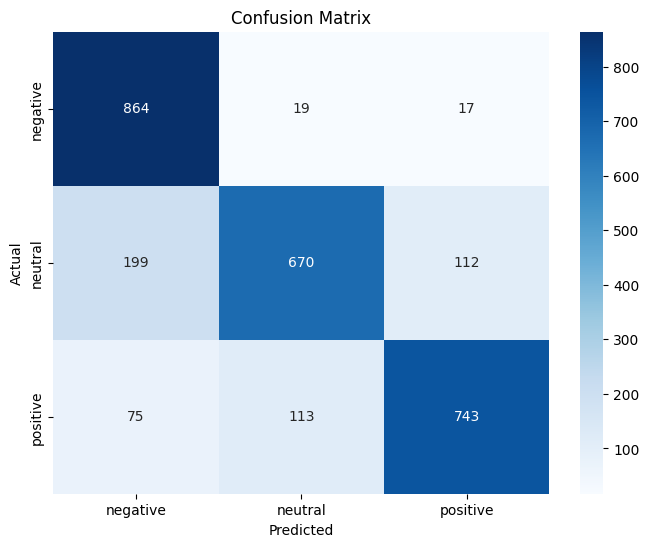

In [48]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#Test Model

In [49]:
def prediction(text):
  new_texts = preprocessing(text)
  sequences = tokenizer.texts_to_sequences(new_texts)
  padded_sequences = pad_sequences(sequences, maxlen=100)
  predictions = model.predict(padded_sequences)
  predicted_labels = predictions.argmax(axis=-1)
  predicted_class_names = [class_names[label] for label in predicted_labels]
  # Print the results
  for text, predicted_class in zip(new_texts, predicted_class_names):
    print(f"Predicted Class is : {predicted_class}")


In [50]:
texts = ["According to its notice , Skandinaviska Enskilda Banken AB publ Helsinki Branch has on 10 August 2009 divested in total 11,958,000 Alma Media shares to Ilkka-Yhtyma Oyj and Kaleva Kustannus Oy , as the conditions of the agreement made by the companies on 1 July 2009 fulfilled .",
         "The agreement will provide The Switch with double the converter capacity"]
prediction(texts)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Predicted Class is : neutral
Predicted Class is : positive
